In [148]:
import numpy as np
#import pytorch as pt
from scipy.sparse import diags, lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt


delta_t = 0.1 #time step
eta = 1 # 0.1
M = 1
gamma = 0.05
epsilon = 1 # 0.04
Re = 1
rho = 1/Re
m = 6 #grid point
x_0, x_m = 0, 1
y_0, y_m = 0, 1
h = (x_m - x_0) / (m)
t_e = 5
T = 10
C0 = 0

In [149]:
x, delta_x = np.linspace(x_0, x_m, m+1, retstep = True)
y, delta_y = np.linspace(y_0, y_m, m+1, retstep = True)
X, Y = np.meshgrid(x[1:m], y[1:m], indexing = 'ij')


x_mod = np.zeros((m-1)**2)
y_mod = y[1:m]
for i in range(m-2):
    x_mod[i*m : i*m+m] = x[i+1]
    y_mod = np.vstack((y_mod, y[1:m]))
y_mod = y_mod.flatten()


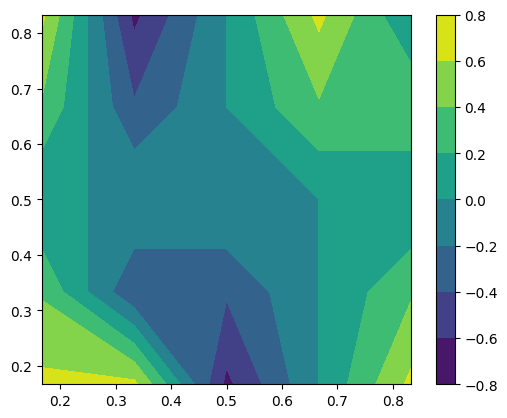

In [199]:
phi_init_ = np.sin(4*np.pi*x_mod)*np.sin(2*np.pi*y_mod) * np.cos(np.pi*y_mod)
phi_plot = np.reshape(phi_init_, (m-1, m-1))
plt.contourf(X, Y, phi_plot)
plt.axis('scaled')
plt.colorbar()
plt.show()

In [194]:
def f_0(phi, epsilon):
    return 1./(4*epsilon**2) * (1-phi**2)**2

#function to calculate f_0^prime
def f_0_prime(phi, epsilon):
    return -(1-phi**2)*phi/epsilon**2

def E(phi, m, h):
    #gradient of phi wrt x
    gradx_phi = gradient_mat(m, h,np.ones((m**2, 1)), 1, 'x').dot(phi)
    #gradient of phi wrt y
    grady_phi = gradient_mat(m,h,np.ones((m**2, 1)), 1, 'y').dot(phi)
    #square of norm of grad phi
    norm_grad_phi = 1/2*(np.square(gradx_phi) + np.square(grady_phi))
    f0 = f_0(phi, epsilon)
    #integrand
    integrand = f0 + norm_grad_phi
    #perform integration
    w_B = 0.5*h*h #boundary values' weight
    w = h*h #weight of inner grids' value
    w_C = 0.25*h*h #corner values' weight
    integral = 0
    for i in range(m**2):
        if i == 0 or i == m-1 or i == m**2-m or i == m**2-1:
            integral += integrand[i] * w_C
        elif i < m or i > m**2-m or i % m == 0 or i % m == m-1:
            integral += integrand[i] * w_B
        else:
            integral += integrand[i] * w
    return integral
    
def mu_init(m, phi, epsilon):
    #print(poisson_des(m, h, -1).shape)
    #print(phi.shape)
    poisson_term = poisson_des(m, h, -epsilon**2).dot(phi)
    nonlinear_term = f_0_prime(phi, epsilon)
    #print(nonlinear_term.shape, "mu_init")
    return poisson_term + nonlinear_term

def poisson_des(m, h, s):
    laplacian = lil_matrix((m**2, m**2))
    laplacian.setdiag(-4*np.ones(m**2)/(h**2))
    for i in range(m**2):
        if i % m != 0:
            laplacian[i,i-1] = 1/(h**2) * s
        if (i+1) % m != 0:
            laplacian[i, i+1] = 1/(h**2) * s
    for i in range(m**2 - m):
        laplacian[i, i+m] = 1/(h**2) * s
        laplacian[i+m, i] = 1/(h**2) * s
    #print(laplacian.shape)

    '''
    for i in range(m):
        laplacian[i, m*(m-1)+i] = s/(h**2)
        laplacian[m*(m-1)+i, i] = s/(h**2)

    # Connect the first and last columns
    for i in range(m):
        laplacian[i*m, (i+1)*m-1] = s/(h**2)
        laplacian[(i+1)*m-1, i*m] = s/(h**2)
        '''
    return laplacian.tocsr()

#function to build gradient matrix and also deal with the convection term
def gradient_mat(m, h, u, s, x_or_y):
#u is the first operand of the convection term (u,grad(x)), u size m**2x1
#u is a vector for the inner product with the gradient matrix
#s is a scalar to be multiplied to the gradient matrix
#x_or_y indicate it's gradient wrt x or wrt y
    if (x_or_y == 'x'):
    #x-component of gradient (gradient along x)
        grad = lil_matrix((m**2, m**2))
        for i in range(m):
            for j in range(m-2):
                grad[i*m+j+1, i*m+j] = -s/(2*h) * u[i*m+j+1]
                grad[i*m+j+1, i*m+j+2] = s/(2*h) * u[i*m+j+1]
        for i in range(m):
            grad[i*m, i*m] = -3*s/(2*h) * u[i*m]
            grad[i*m, i*m+1] = 4*s/(2*h) * u[i*m]
            grad[i*m, i*m+2] = -s/(2*h) * u[i*m]
            grad[(i+1)*m-1, (i+1)*m-1] = 3*s/(2*h) * u[(i+1)*m-1]
            grad[(i+1)*m-1, (i+1)*m-2] = -4*s/(2*h) * u[(i+1)*m-1]
            grad[(i+1)*m-1, (i+1)*m-3] = s/(2*h) * u[(i+1)*m-1]
        return grad.tocsr()
    else:
    #y-component of gradient (gradient along y)
        grad = lil_matrix((m**2, m**2))
        #first and last row of grid points
        for i in range(m):
            #first row
            grad[i, i] = -3*s/(2*h) * u[i]
            grad[i, m+i] = 4*s/(2*h) * u[i]
            grad[i, 2*m+i] = -s/(2*h) * u[i]
            #last row
            grad[m*m-1-i, m*m-1-i] = 3*s/(2*h) * u[m*m-1-i]
            grad[m*m-1-i, m*m-1-i-m] = -4*s/(2*h) * u[m*m-1-i]
            grad[m*m-1-i, m*m-1-i-2*m] = s/(2*h) * u[m*m-1-i]
        #middle rows of grid points
        for i in range((m-2)*m):
            grad[i+m, i] = -s/(2*h) * u[i+m]
            grad[i+m, i+2*m] = s/(2*h) * u[i+m]
        return grad.tocsr()

def scalar_mul(s, m):
#s is the scalar, m is the size
    scalar = lil_matrix((m**2, m**2))
    for i in range(0, m**2):
        scalar[i, i] = s
    #return csr_matrix(scalar)
    return scalar#TODO

#function for calculating divergence
#u is a vector with 2 components (2D array)
def div_val(m, h, u, s):
    div_x = gradient_mat(m, h, np.ones(m**2), s, 'x')
    div_y = gradient_mat(m, h, np.ones(m**2), s, 'y')
    div = div_x.dot(u[0,:]) + div_y.dot(u[1,:])
    return div

#function to generate biharmonic discretization matrix
def biharmonic(m, h, s):
    poisson = poisson_des(m, h, s)
    biharmonic = csr_matrix(poisson.dot(poisson))
    return biharmonic

def Euler_one_step(m, h, delta_t, M, p, phi, rho, eta, \
                epsilon, C0):
    # first, calculate phi_mid, b_n and r
    phi_mid = helper_phi_mid(m, h, delta_t, phi)
    b_n = helper_b(m, h, phi_mid, C0)
    r = helper_r(m, h, phi, C0)
    # then solve for phi_n+1
    phi_n = phi/4
    phi_n_minus = np.zeros(m**2)
    phi_n_plus = solve_phi(m, h, delta_t, M, epsilon, phi_n, \
                phi_n_minus, b_n, C0) #this is phi_n+1

    return p, phi_n_plus

def BDF2_one_step(m, h, delta_t, M, p, phi_n, phi_n_minus,\
            rho, eta, epsilon, C0):
    # first, calculate phi_mid, b_n and r
    phi_mid = helper_phi_mid(m, h, delta_t, phi_n)
    b_n = helper_b(m, h, phi_mid, C0)
    r = helper_r(m, h, phi_n, C0)
    # then solve for phi_n+1
    phi_n_plus = solve_phi(m, h, delta_t, M, epsilon, phi_n, \
                phi_n_minus, b_n, C0) #this is phi_n+1

    return p, phi_n_plus

def time_stepping(m, h, delta_t, t_e, T, x, y, eta, rho, epsilon, M, C0):
    #calculate the initial values
    mu_init_ = mu_init(m, phi_init_, epsilon)
    p_init_ = p_init(phi_init_, mu_init_, eta, rho, m, h)
    # changing the initial pressure TODO
    #p_init_ = np.zeros(m**2)

    #start time stepping
    #first do Euler time stepping 10 times
    delta_t_euler = delta_t / t_e
    p = p_init_
    print("p_init_;", p_init_)#TODO

    phi_n_minus = phi_init_
    phi_n = phi_init_
    print("phi_init", phi_init_)


    for i in range(t_e):
        if i == 0:
            p, phi_n = Euler_one_step(m, h, delta_t_euler, M, \
                    p, phi_n_minus, rho, eta, epsilon, C0)
            continue
        print("i: ", i)#TODO
        p, phi = BDF2_one_step(m, h, delta_t_euler, M, \
                p, phi_n, phi_n_minus, rho, eta, \
                epsilon, C0)
        #update n_minus and n variables
        phi_n_minus = phi_n
        phi_n = phi

        phi_plot = np.reshape(phi, (m,m))
        plt.contourf(X, Y, phi_plot)
        plt.axis('scaled')
        plt.title(f"phi {i}")
        plt.colorbar()
        plt.show()

    for i in range(T - 1):
        print("i", i)
        if i == 0:
            phi_n_minus = phi_init_
        p, phi = BDF2_one_step(m, h, delta_t, M, p,\
                phi_n, phi_n_minus, rho, eta, epsilon, C0)
        #update n_minus and n variable
        phi_n_minus = phi_n
        #print("u_n vetor:", u_n)
        phi_n = phi

        phi_plot = np.reshape(phi, (m,m))
        plt.contourf(X, Y, phi_plot)
        plt.axis('scaled')
        plt.title(f"phi {i}")
        plt.colorbar()
        plt.show()

    return p, phi_n

def plotting(m, h, delta_t, t_e, T, x, y, eta, rho, epsilon, M, C0):
    p, phi = time_stepping(m, h, delta_t, t_e, T, x, y, eta, \
                        rho, epsilon, M, C0)
    phi_plot = np.reshape(phi, (m, m))
    plt.contourf(X, Y, phi_plot)
    plt.axis('scaled')
    plt.title('phi_final')
    plt.colorbar()
    plt.show()

def helper_mu(m, h, phi_n, epsilon, C0):
    poisson_phi = poisson_des(m, h, -epsilon**2).dot(phi_n)
    r = helper_r(m, h, phi_n, C0)
    f_term = r * helper_b(m, h, phi_n, C0)
    return poisson_phi + f_term

def p_init(phi, mu, eta, rho, m, h):#TODO
    #LHS-grad p
    grad = poisson_des(m, h, 1)
    
    #terms involving phi and mu
    grad_phi_x = gradient_mat(m, h, np.ones(m**2), -1, 'x').dot(phi)
    grad_phi_y = gradient_mat(m, h, np.ones(m**2), -1, 'y').dot(phi)
    #print(grad_phi_x.shape)#TODO
    grad_mu_x = gradient_mat(m, h, grad_phi_x, 1, 'x').dot(mu)
    grad_mu_y = gradient_mat(m, h, grad_phi_y, 1, 'y').dot(mu)
    grad_mu_term = grad_mu_x + grad_mu_y
    poisson_mu = poisson_des(m, h, -1).dot(mu) * phi

    RHS = poisson_mu + grad_mu_term 
    #solve for p_initial
    p = spsolve(grad, RHS)
    return p

    
#function to solve phi after solving u_hat_n+1
#This function is using u_hat as u_n+1 and not the real u_n+1 when
#solving for phi. TODO
def solve_phi(m, h, delta_t, M, epsilon, phi_n,\
            phi_n_minus, b, C0):
    #RHS
    b_phi_ip, RHS_2 = b_phi_inner_product(m, h, delta_t, M, \
        epsilon, phi_n, phi_n_minus, b, C0)

    first_term_coef = M/2 * b_phi_ip
    poisson_b = poisson_des(m, h, 1).dot(b) * first_term_coef
    RHS_1 = A_inverse_b(m, h, delta_t, M, epsilon, poisson_b)
    RHS = RHS_1 + RHS_2
    return RHS #phi_n+1 equals RHS

def gamma(m, h, delta_t, M, epsilon, b):
    poisson_b = poisson_des(m, h, 1).dot(b)
    A_term = A_inverse_b(m, h, delta_t, M, epsilon, poisson_b)
    return -M/2 * A_term * b

#helper: compute <b, phi_n+1>, it will also return A^-1*g
def b_phi_inner_product(m, h, delta_t, M, epsilon, phi_n,\
                        phi_n_minus, b, C0):
    #RHS (g_term)
    #div_u_hat = div_val(m, h, u_hat, -1/2)
    #scalar_phi = (2/delta_t + div_u_hat) * phi_n
    scalar_phi = (2/delta_t) * phi_n
    # divergence phi term
    #div_phi = div_val(m, h, phi_n, -1)
    #u_div_phi = (u_hat + u_n_minus)/2 * div_phi
    # phi_n-1 term
    scalar_phi_minus = -phi_n_minus/(2*delta_t)
    # laplacian b term
    r = helper_r(m, h, phi_n, C0)
    r_minus = helper_r(m, h, phi_n_minus, C0)
    laplacian_b_coef = 4*M/3*r - 2*M/3*(b*phi_n) + M/6*(b*phi_n_minus)\
        - M/3*r_minus
    laplacian_b = poisson_des(m, h, 1).dot(b) * laplacian_b_coef

    g = scalar_phi + scalar_phi_minus + laplacian_b
    A_inverse_g = A_inverse_b(m, h, delta_t, M, epsilon, g)

    RHS = A_inverse_g * b
    #LHS
    LHS = 1 + gamma(m, h, delta_t, M, epsilon, b)

    result = RHS/LHS
    return result, A_inverse_g

def helper_phi_mid(m, h, delta_t, phi_n):
    #LHS 
    #scalar term
    identity = scalar_mul(1,m)
    #biharmonic term
    biharmonic_ = biharmonic(m, h, delta_t)
    #print("biharmonic:", biharmonic_.shape)
    #print("idnetity:", identity.shape)
    LHS = biharmonic_ + identity
    #RHS
    f_prime = poisson_des(m, h, delta_t).dot(f_0_prime(phi_n, epsilon))
    RHS = f_prime + phi_n
    #solve for phi_middle
    phi_mid = spsolve(LHS, RHS)
    return phi_mid

#helper function to calculate r
def helper_r(m, h, phi_n, C0):
    #f_0_n = f_0(phi_n, epsilon)
    r = np.sqrt(E(phi_n, m, h) + C0)
    return r

#helper function to solve b_n
def helper_b(m, h, phi_mid, C0):
    numerator = f_0_prime(phi_mid, epsilon)
    #f_0_mid = f_0(phi_mid, epsilon)
    denominator = np.sqrt(E(phi_mid, m, h)+C0)
    return numerator / denominator

#helper: solve Ax=(b)
def A_inverse_b(m, h, delta_t, M, epsilon, poisson_b):
    #LHS (A)
    scalar_ = scalar_mul(3/(2*delta_t), m)
    biharmonic_ = biharmonic(m, h, M*epsilon**2)
    A = scalar_ + biharmonic_
    #solve for A_inverse_poisson_b
    result = spsolve(A, poisson_b)
    return result


p_init_; [-281.73658801 -291.81376183 -239.50593572 -347.91655955 -380.81937022
 -378.86396778 -358.62624175 -318.29342153 -353.27555803 -298.89610316
 -294.76662526 -362.4468311  -321.76595059 -318.85305557 -239.92351057
 -210.51550178 -275.29521704 -278.92002997 -331.30784626 -279.77622984
 -209.83151112 -217.62789848 -178.76064179 -218.49463869 -188.89195962]
phi_init [ 6.49519053e-01  3.75000000e-01  6.49415036e-33  3.75000000e-01
  6.49519053e-01  6.49519053e-01 -3.75000000e-01 -6.49415036e-33
 -3.75000000e-01 -6.49519053e-01 -6.49519053e-01 -3.75000000e-01
 -1.83667602e-48 -1.06057524e-16 -1.83697020e-16 -1.83697020e-16
 -1.06057524e-16 -1.83667602e-48  3.75000000e-01  6.49519053e-01
  6.49519053e-01  3.75000000e-01  6.49415036e-33  3.75000000e-01
  0.00000000e+00]
i:  1


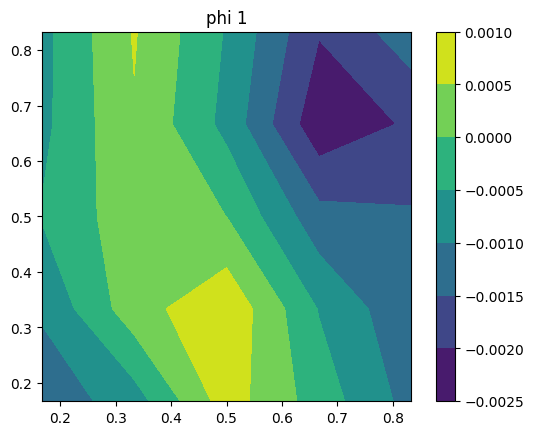

i:  2


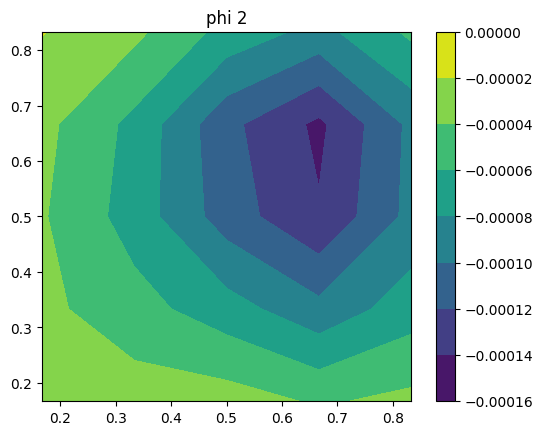

i:  3


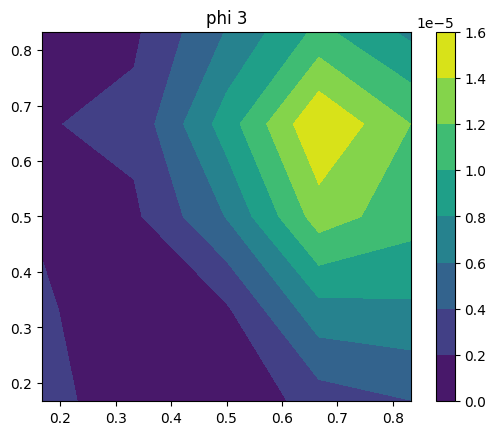

i:  4


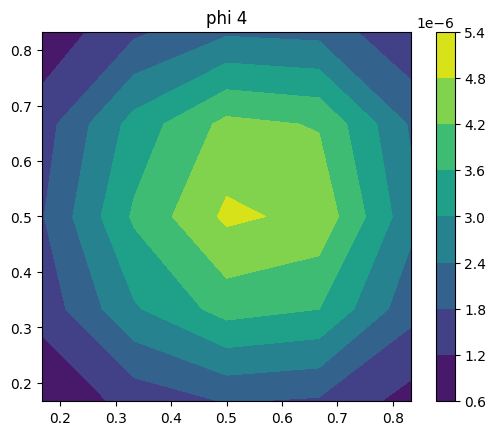

i 0


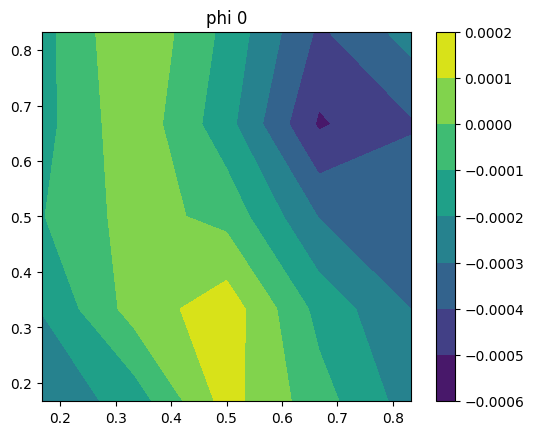

i 1


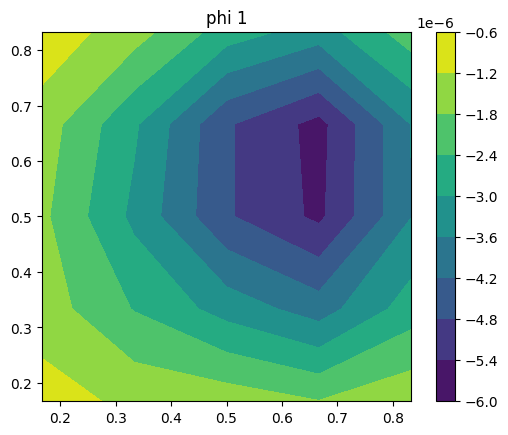

i 2


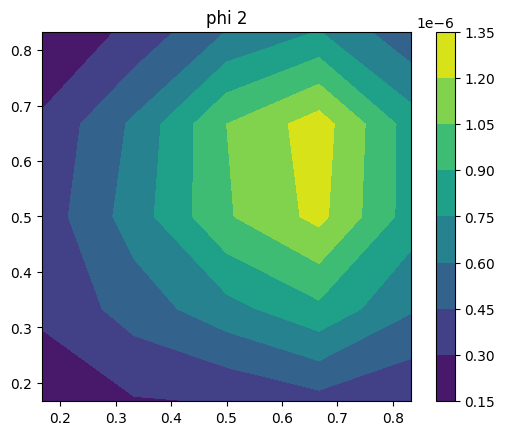

i 3


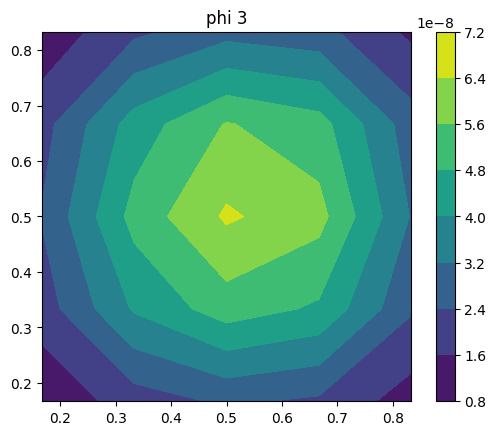

i 4


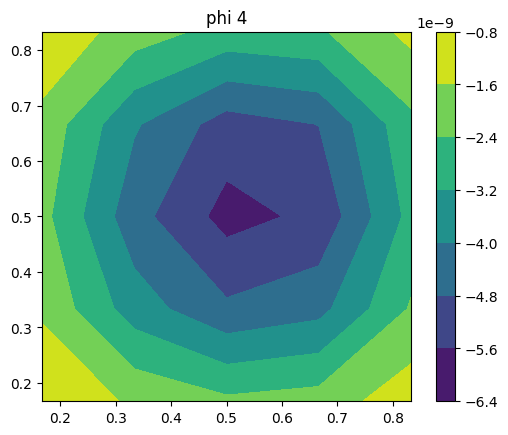

i 5


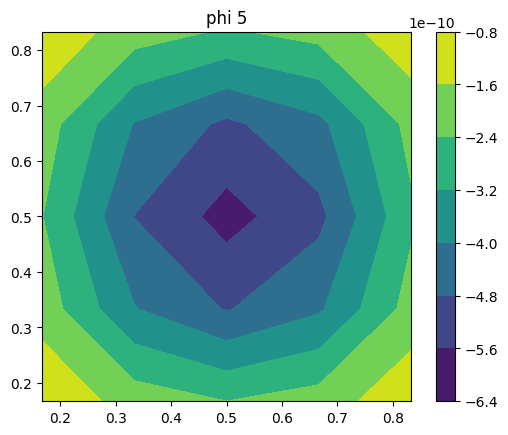

i 6


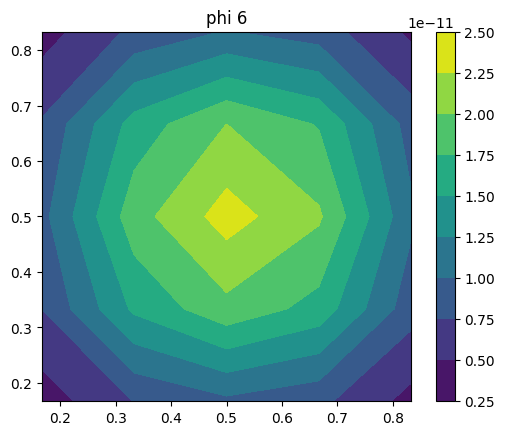

i 7


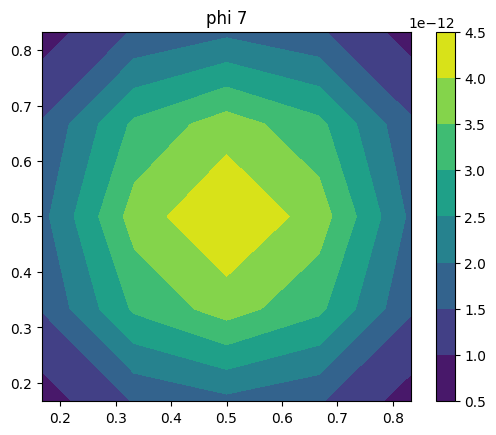

i 8


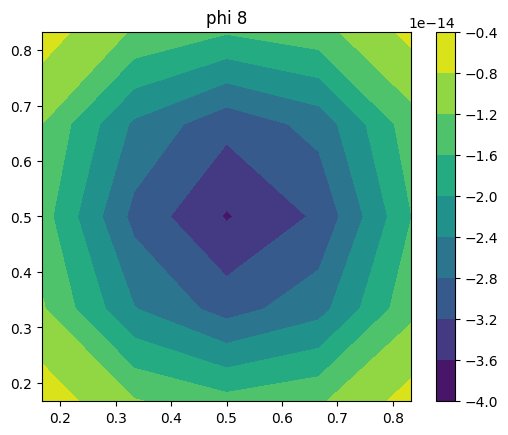

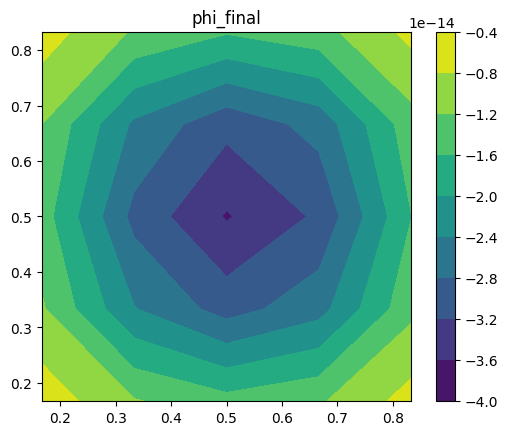

In [200]:
plotting(m-1, delta_x, delta_t, t_e, T, x_mod, y_mod, eta, rho, epsilon, M, C0)

[-72. -36. -36. -36. -72. -36.   0.   0.   0. -36. -36.   0.   0.   0.
 -36. -36.   0.   0.   0. -36. -72. -36. -36. -36. -72.]
phi_init  [ 7.50000000e-01  7.50000000e-01  1.06057524e-16 -7.50000000e-01
 -7.50000000e-01  7.50000000e-01 -7.50000000e-01 -1.06057524e-16
  7.50000000e-01  7.50000000e-01 -7.50000000e-01 -7.50000000e-01
 -2.99951957e-32  2.12115048e-16  2.12115048e-16 -2.12115048e-16
 -2.12115048e-16 -2.99951957e-32 -7.50000000e-01 -7.50000000e-01
  7.50000000e-01  7.50000000e-01  1.06057524e-16 -7.50000000e-01
 -0.00000000e+00]


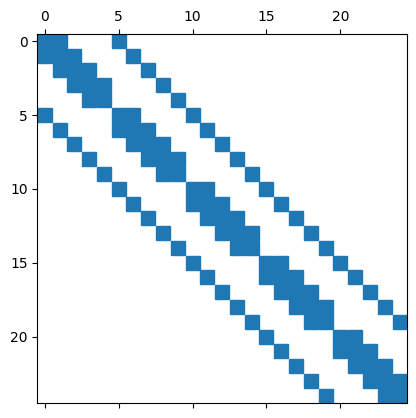

In [175]:
# testing the function p_init
m_ = m -1
grad = poisson_des(m_, h, 1)
test_x = np.ones(m_**2)
test_b = grad.dot(test_x)
print(test_b)
print("phi_init ", phi_init_)
#print(grad.toarray())
plt.spy(grad)
plt.show()

In [ ]:
def p_init(phi, mu, eta, rho, m, h):#TODO
    #LHS-grad p
    grad = poisson_des(m, h, 1)
    
    #terms involving phi and mu
    grad_phi_x = gradient_mat(m, h, np.ones(m**2), -1, 'x').dot(phi)
    grad_phi_y = gradient_mat(m, h, np.ones(m**2), -1, 'y').dot(phi)
    #print(grad_phi_x.shape)#TODO
    grad_mu_x = gradient_mat(m, h, grad_phi_x, 1, 'x').dot(mu)
    grad_mu_y = gradient_mat(m, h, grad_phi_y, 1, 'y').dot(mu)
    grad_mu_term = grad_mu_x + grad_mu_y
    poisson_mu = poisson_des(m, h, -1).dot(mu) * phi

    RHS = poisson_mu + grad_mu_term 
    #solve for p_initial
    p = spsolve(grad, RHS)
    return p

def mu_init(m, phi, epsilon):
    #print(poisson_des(m, h, -1).shape)
    #print(phi.shape)
    poisson_term = poisson_des(m, h, -epsilon**2).dot(phi)
    nonlinear_term = f_0_prime(phi, epsilon)
    return poisson_term + nonlinear_term


In [167]:
'''
#poisson space descretization(periodic BC)
def poisson_des(m, h, s):
    laplacian = lil_matrix((m**2, m**2))
    laplacian.setdiag(-4*np.ones(m**2)/(h**2))
    for i in range(m**2):
        if i % m != 0:
            laplacian[i,i-1] = 1/(h**2) * s
        if (i+1) % m != 0:
            laplacian[i, i+1] = 1/(h**2) * s
    for i in range(m**2 - m):
        laplacian[i, i+m] = 1/(h**2) * s
        laplacian[i+m, i] = 1/(h**2) * s

    #connecting the first and last rows
    for i in range(m):
        laplacian[i, m*(m-2)+i] = s/(h**2)
        laplacian[m*(m-1)+i, i+m] = s/(h**2)

    # Connect the first and last columns
    for i in range(m):
        laplacian[i*m, (i+1)*m-2] = s/(h**2)
        laplacian[(i+1)*m-1, i*m+1] = s/(h**2)
    
    #print(laplacian)
    return laplacian.tocsr()
'''
poisson_term = poisson_des(m_, h, -epsilon**2).dot(phi_init_)
print(poisson_term)
nonlinear_term = f_0_prime(phi_init_, epsilon)
print(nonlinear_term)
mu_init_ = mu_init(m_, phi_init_, epsilon)
print("mu_init_ ",mu_init_)

[-1.62000000e+02 -1.08000000e+02 -2.46036386e-14  1.08000000e+02
  1.08000000e+02 -8.10000000e+01  8.10000000e+01  2.13162821e-14
 -1.08000000e+02 -1.08000000e+02  1.08000000e+02  1.62000000e+02
  2.70000000e+01 -1.77635684e-14 -1.42108547e-14  1.42108547e-14
  1.42108547e-14  2.70000000e+01  1.62000000e+02  1.35000000e+02
 -1.35000000e+02 -1.35000000e+02 -2.84217094e-14  1.35000000e+02
  5.40000000e+01]
[-3.28125000e-01 -3.28125000e-01 -1.06057524e-16  3.28125000e-01
  3.28125000e-01 -3.28125000e-01  3.28125000e-01  1.06057524e-16
 -3.28125000e-01 -3.28125000e-01  3.28125000e-01  3.28125000e-01
  2.99951957e-32 -2.12115048e-16 -2.12115048e-16  2.12115048e-16
  2.12115048e-16  2.99951957e-32  3.28125000e-01  3.28125000e-01
 -3.28125000e-01 -3.28125000e-01 -1.06057524e-16  3.28125000e-01
  0.00000000e+00]
mu_init_  [-1.62328125e+02 -1.08328125e+02 -2.47096961e-14  1.08328125e+02
  1.08328125e+02 -8.13281250e+01  8.13281250e+01  2.14223396e-14
 -1.08328125e+02 -1.08328125e+02  1.08328125

In [168]:
grad_phi_x = gradient_mat(m_, h, np.ones(m**2), -1, 'x').dot(phi_init_)
grad_phi_y = gradient_mat(m_, h, np.ones(m**2), -1, 'y').dot(phi_init_)
print(grad_phi_x)#TODO
grad_mu_x = gradient_mat(m_, h, grad_phi_x, 1, 'x').dot(mu_init_)
grad_mu_y = gradient_mat(m_, h, grad_phi_y, 1, 'y').dot(mu_init_)
print(grad_mu_x)
grad_mu_term = grad_mu_x + grad_mu_y
poisson_mu = poisson_des(m_, h, -1).dot(mu_init_) * phi_init_
print(poisson_mu)

RHS = poisson_mu + grad_mu_term 

print(RHS)

[-2.25000000e+00  2.25000000e+00  4.50000000e+00  2.25000000e+00
 -2.25000000e+00  1.57500000e+01  2.25000000e+00 -4.50000000e+00
 -2.25000000e+00  2.25000000e+00  2.25000000e+00 -2.25000000e+00
 -2.25000000e+00 -6.36345143e-16  6.36345143e-16  6.36345143e-16
 -6.36345143e-16  2.25000000e+00  2.25000000e+00 -2.25000000e+00
 -2.25000000e+00  2.25000000e+00  4.50000000e+00  3.18172572e-16
 -9.00000000e+00]
[-3.62285156e+02  1.09571484e+03  2.92485938e+03  7.31214844e+02
  7.31214844e+02  2.68992773e+04  5.48964844e+02  2.56035937e+03
  7.31214844e+02  7.31214844e+02  2.00696484e+03  5.48964844e+02
  1.09571484e+03  5.15439566e-14  5.15439566e-14 -5.15439566e-14
 -5.15439566e-14  1.09571484e+03  7.31214844e+02  1.46021484e+03
  9.13464844e+02  9.13464844e+02  3.65385938e+03  5.15439566e-14
  1.02414375e+04]
[ 2.26521563e+04  1.38864375e+04  4.48731148e-28  1.16994375e+04
  1.16994375e+04  8.04557813e+03  8.04557812e+03  2.65261579e-28
  1.16994375e+04  1.16994375e+04  1.38864375e+04  2.33

In [132]:
p = spsolve(grad, RHS)

RHS_test = np.array([2, 3, 4, 3, 5])
identity = np.eye(5)

test = spsolve(identity, RHS_test)
print(test)

print(grad*p)
from scipy.sparse.linalg import norm

# Compute the condition number of the sparse matrix
condition_number = norm(grad, ord=2) * norm(grad, ord=np.inf)
print("Condition number:", condition_number)

[2. 3. 4. 3. 5.]
[ 196608. -393216.  131072. -131072. -131072. -393216.  -65536.  131072.
   65536.  196608.  -65536.       0. -196608.  393216.  262144.       0.
   65536. -131072. -262144.  131072.   65536. -196608.  262144.  393216.
 -262144.]
Condition number: 36180.33988749894


/var/folders/r1/1z_0fp4d0jzbn22kmxqqcf3m0000gn/T/ipykernel_27446/2455870163.py:6: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  test = spsolve(identity, RHS_test)


In [196]:
def helper_phi_mid(m, h, delta_t, phi_n):
    #LHS 
    #scalar term
    identity = scalar_mul(1,m)
    #print(identity)
    #biharmonic term
    biharmonic_ = biharmonic(m, h, delta_t)
    #print(biharmonic_)
    LHS = biharmonic_ + identity
    #RHS
    f_prime = poisson_des(m, h, delta_t).dot(f_0_prime(phi_n, epsilon))
    RHS = f_prime + phi_n
    #solve for phi_middle
    phi_mid = spsolve(LHS, RHS)
    return phi_mid

#helper function to calculate r
def helper_r(m, h, phi_n, C0):
    #f_0_n = f_0(phi_n, epsilon)
    r = np.sqrt(E(phi_n, m, h) + C0)
    #print("E ", E(phi_n, m, h))
    return r

#helper function to solve b_n
def helper_b(m, h, phi_mid, C0):
    numerator = f_0_prime(phi_mid, epsilon)
    #f_0_mid = f_0(phi_mid, epsilon)
    denominator = np.sqrt(E(phi_mid, m, h)+C0)
    return numerator / denominator
'''
def biharmonic(m, h, s):
    poisson = poisson_des(m, h, s)
    biharmonic = csr_matrix(poisson.dot(poisson))
    return biharmonic
'''

'\ndef biharmonic(m, h, s):\n    poisson = poisson_des(m, h, s)\n    biharmonic = csr_matrix(poisson.dot(poisson))\n    return biharmonic\n'

In [197]:
def biharmonic(m, h, s):
    bh = lil_matrix((m**2, m**2))
    bh.setdiag(20*np.ones(m**2)/(h**4))
    for i in range(m**2):
        if i % m != 0:
            bh[i, i-1] = -8/(h**4) * s
            if i % m != 1: #not the second column
                bh[i, i-2] = 1/(h**4) * s #u_{i,j-2}
        if (i+1) % m != 0:
            bh[i, i+1] = -8/(h**4) * s
            if (i+2) % m != 0: #not the second last column
                bh[i, i+2] = 1/(h**4) * s #u_{i,j+2}
    for i in range(m**2 - m):
        bh[i, i+m] = -8/(h**4) * s #u_{i+1,j}
        bh[i+m, i] = -8/(h**4) * s #u_{i-1,j}
    for i in range(m**2 -m -1):
        if (i+1) % m != 0: #not the last column
            bh[i, i+m+1] = 2/(h**4) * s #u_{i+1,j+1} 
        #if (i+m+1) % m != 0: #not the first column
            bh[i+m+1, i] = 2/(h**4) * s #u_{i-1,j-1}
    for i in range(m**2-m+1):
        if i % m != 0:
            bh[i+m-1, i] = 2/(h**4) * s #u_{i-1,j+1}
            bh[i, i+m-1] = 2/(h**4) * s #u_{i+1,j-1}
    for i in range(m**2-2*m):
        bh[i, i+2*m] = 1/(h**4) * s #u_{i+2,j}
        bh[i+2*m, i] = 1/(h**4) * s #u_{i-2,j}
    #plt.spy(bh)
    #plt.show()
    return bh.tocsr()

In [188]:
phi_mid = helper_phi_mid(m_, h, delta_t, phi_init_)
print(phi_mid)
b_n = helper_b(m_, h, phi_mid, C0)
print("b_n ", b_n)
r = helper_r(m_, h, phi_init_, C0)
print("r ", r)

[ 1.93567928e-03  1.85644002e-03 -1.63742343e-06 -1.87930901e-03
 -1.87066876e-03  1.82786454e-03 -1.83793840e-03  2.76952129e-06
  1.89048690e-03  1.88089805e-03 -1.85763806e-03 -1.94508854e-03
 -3.40596956e-06  2.76026909e-05  1.11921474e-05 -6.70904719e-06
  1.63106795e-05 -1.93771689e-06 -1.91892862e-03 -1.87502784e-03
  1.89109355e-03  1.90212038e-03  1.07934261e-05 -1.87500194e-03
 -3.97744653e-05]
b_n  [-5.80553132e-03 -5.56787686e-03  4.91101429e-06  5.63646558e-03
  5.61055174e-03 -5.48217324e-03  5.51238679e-03 -8.30643948e-06
 -5.66999033e-03 -5.64123145e-03  5.57147005e-03  5.83375154e-03
  1.02152961e-05 -8.27868997e-05 -3.35678571e-05  2.01219954e-05
 -4.89195274e-05  5.81166432e-06  5.75529273e-03  5.62362550e-03
 -5.67180978e-03 -5.70488146e-03 -3.23719991e-05  5.62354783e-03
  1.19292886e-04]
r  3.0509132338252205


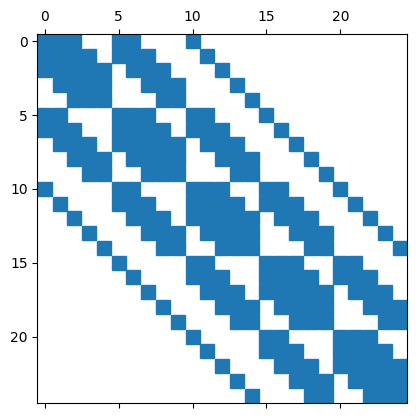

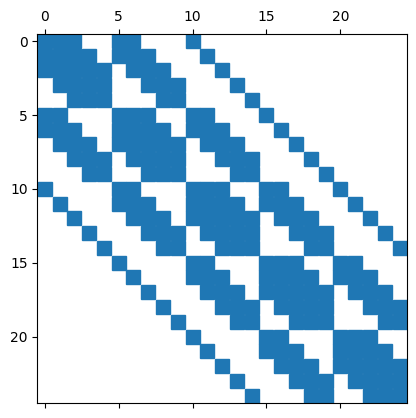

In [189]:
bh = biharmonic(m_, h, 1)
plt.spy(bh)
plt.show()
bh2 = poisson_des(m_, h, 1).dot(poisson_des(m_, h, 1))
plt.spy(bh2)
plt.show()